In [1]:
import random
import torch
from torchvision import transforms
from torchvision.datasets import STL10
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#Getting dataset

root = "./data"
train_set = STL10(root=root, split="train", download=True, transform=None)
unlabeled_set = STL10(root=root, split='unlabeled', download=True, transform=None)
test_set = STL10(root=root, split="test", download=True, transform=None)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Before starting the modelling part, first viewing a few images in the training set and unlabeled set

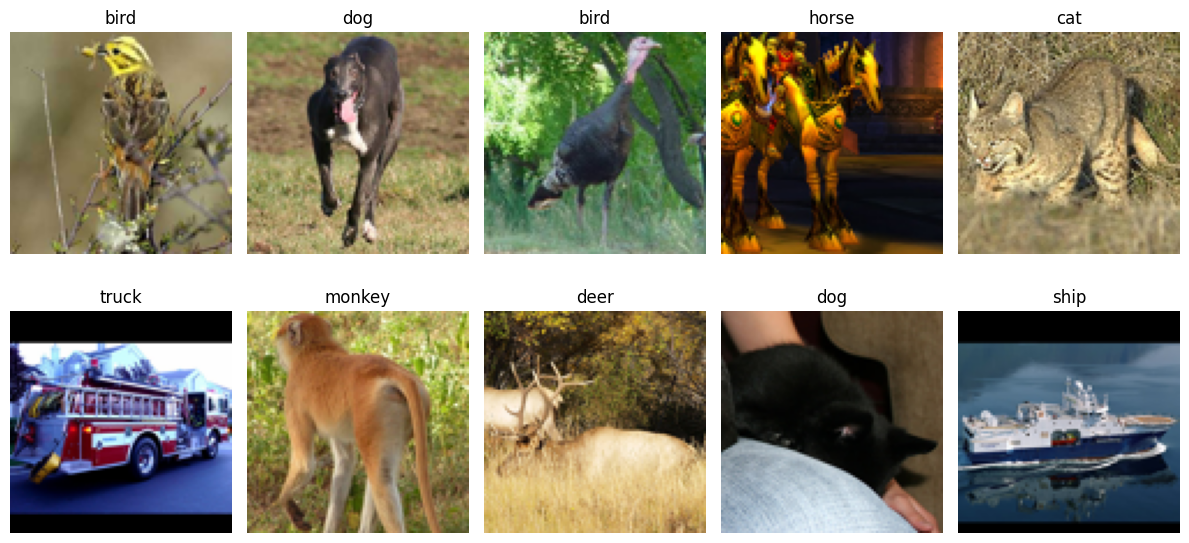

In [3]:
def show_images(images, titles=None, nrows=2, ncols=5, figsize=(12, 6)):
    """
    Display a grid of images.

    Args:
        images (list): List of images to display.
        titles (list): List of titles for each image.
        nrows (int): Number of rows in the grid.
        ncols (int): Number of columns in the grid.
        figsize (tuple): Size of the figure.
    """
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()  # Flatten the 2D array of subplots into a 1D array

    # Ensure the number of images matches the number of subplots
    num_images = len(images)
    if num_images < nrows * ncols:
        print(f"Warning: Only {num_images} images provided, but {nrows * ncols} subplots created.")

    for i, ax in enumerate(axes):
        if i < num_images:
            ax.imshow(images[i])
            ax.axis('off')
            if titles:
                ax.set_title(titles[i])
        else:
            ax.axis('off')  # Hide empty subplots

    plt.tight_layout()
    plt.show()
torch.manual_seed(42)

#displyaing 2x5 grid for traning images
train_images = [train_set[i][0] for i in range(10)] 
train_labels = [train_set.classes[train_set[i][1]] for i in range(10)]  # Corresponding labels
show_images(train_images, titles=train_labels, nrows=2, ncols=5)

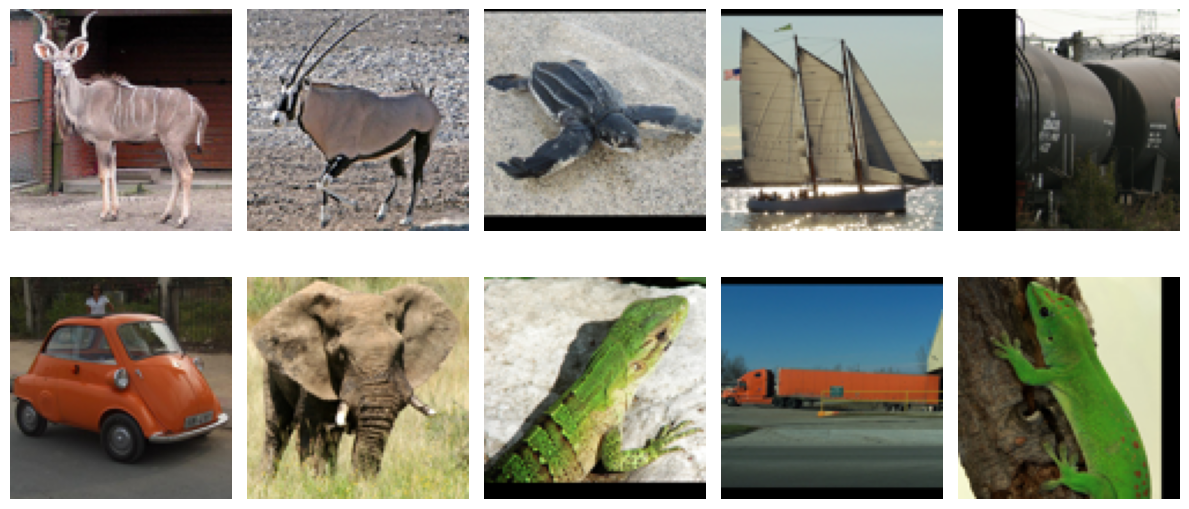

In [4]:
# displaying UNLABELED set images
torch.manual_seed(42)
unlabeled_images = [unlabeled_set[i][0] for i in range(10)]
show_images(unlabeled_images, nrows=2, ncols=5)

While applying augmentation, we will be normalizing as well. For that, we need to know __mean__ and __standard deviation__ .

In [5]:
def compute_mean_std(dataset):
    """
    Compute mean and standard deviation for each channel in the image dataset.
    """
    mean = torch.zeros(3)  
    std = torch.zeros(3)   
    total_pixels = 0

    for image, _ in dataset:
        image = transforms.ToTensor()(image)  # Converting images to tensors
        image = image.view(3, -1)  # Flattening the image to [3, height*width]
        mean += image.sum(dim=1)   # getting the sum of pixel values for each channel
        std += (image ** 2).sum(dim=1)  #getting the sum of squared pixel values for each channel
        total_pixels += image.size(1)

    # Computing the mean and std across the entire dataset
    mean /= total_pixels
    std = torch.sqrt(std / total_pixels - (mean ** 2))

    return mean.tolist(), std.tolist()

mean, std = compute_mean_std(train_set)

print(f"Mean: {mean}")
print(f"Std: {std}")

Mean: [0.44671088457107544, 0.43981093168258667, 0.40664660930633545]
Std: [0.26034072041511536, 0.256574809551239, 0.2712670564651489]


In [6]:
class STL10Augmentation:
    def __init__(self, image_size=96, mean=None, std=None):
        """
        Augmentation pipeline for STL-10 transformations.
        Args:
            image_size (int): Size of the output image (default: 96x96).
            mean (list): Mean for each channel (R, G, B).
            std (list): Standard deviation for each channel (R, G, B).
        """
        self.augment = transforms.Compose([
            #transforms.RandomResizedCrop(size=image_size, scale=(0.2, 1.0)),
            transforms.RandomHorizontalFlip(p=0.3), 
            transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
            transforms.RandomApply([transforms.GaussianBlur(kernel_size=23)], p=0.5), 
            transforms.RandomGrayscale(p=0.2),
            transforms.ToTensor(), 
            transforms.Normalize(mean=mean, std=std)
        ])

    def __call__(self, image):
        """
        Args:
            image (PIL.Image): Input image.
        Returns:
            torch.Tensor: Augmented and normalized image.
        """
        return self.augment(image)

In [7]:
augmentation = STL10Augmentation(mean=mean, std=std)

### Defining the MoCo Model

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

In [9]:
class MoCo(nn.Module):
    def __init__(self, base_encoder, dim=128, queue_size=32768, momentum=0.99, temperature=0.07, mlp=False):
        """
        MoCo model for self-supervised learning.
        Args:
        base_encoder: Base Encoder Network (ResNet)
        dim: Dimension of the output feature vector
        k (int): Size of the queue (number of negative samples)
        m (float): Momentum for updating the key encoder
        T (float): Temperature for the contrastive loss
        """
        super(MoCo, self).__init__()

        self.queue_size = queue_size
        self.momentum = momentum
        self.temperature = temperature

        # creating the query and key encoder
        self.encoder_query = base_encoder(num_classes=dim)
        self.encoder_key = base_encoder(num_classes=dim)

        #initializing key encoder with query encoder weights
        for param_query, param_key in zip(self.encoder_query.parameters(), self.encoder_key.parameters()):
            param_key.data.copy_(param_query.data)
            param_key.requires_grad = False #freezing key encoder

        #queue for negative samples
        self.register_buffer("queue", torch.randn(dim, queue_size))
        self.queue = F.normalize(self.queue, dim=0)

        self.register_buffer("queue_ptr", torch.zeros(1, dtype=torch.long))

    @torch.no_grad()
    def _momentum_update_key_encoder(self):
        """
        Momentum update of the key encoder
        """
        for param_query, param_key in zip(self.encoder_query.parameters(), self.encoder_key.parameters()):
            param_key.data = param_key.data * self.momentum + param_query.data * (1.0 - self.momentum)

    @torch.no_grad()
    def dequeue_and_enqueue(self, keys):
        batch_size = keys.shape[0]
        ptr = int(self.queue_ptr)

        # handling the case where batch_size doesn't divide evenly into self.K
        remaining = self.queue_size - ptr
        if remaining < batch_size:
           self.queue[:, ptr:ptr + remaining] = keys[:remaining].T
           self.queue[:, 0:batch_size - remaining] = keys[remaining:].T
        else:
           self.queue[:, ptr:ptr + batch_size] = keys.T

        ptr = (ptr + batch_size) % self.queue_size
        self.queue_ptr[0] = ptr

    def forward(self, query_image, key_image):
        """
        Args:
            query_image: a batch of query images (N x C x H x W)
            key_image: a batch of key images (N x C x H x W)
        Returns:
            logits: N x (1xK)
            labels: N
        """

        #query feature
        query_features = self.encoder_query(query_image)
        # if self.mlp:
        #     query_features = self.mlp_head_query(query_features)
        query_features = F.normalize(query_features, dim=1)

        #key features
        with torch.no_grad():
            self._momentum_update_key_encoder()
            key_features = self.encoder_key(key_image)
            key_features = F.normalize(key_features, dim=1)

        #computing logits
        logit_positive = torch.einsum("nc, nc->n",[query_features, key_features]).unsqueeze(-1)
        logit_negative = torch.einsum("nc,ck->nk",[query_features, self.queue.clone().detach()])
        logits = torch.cat([logit_positive, logit_negative],dim=1) /self.temperature #applying temperature

        #labels: the first column (positive key) is the ground truth
        labels = torch.zeros(logits.shape[0], dtype=torch.long)

        #updating the queue
        self.dequeue_and_enqueue(key_features)

        return logits, labels

### Defining the Base Encoder

In [10]:
def resnet18(num_classes=128):
  """
  creating a resnet18 model with custom output dimension
  Args:
  num_classes (int): Dimension of the output feature vector
  """
  model = models.resnet18(weights=None)
  model.fc = nn.Linear(model.fc.in_features, num_classes)
  return model

### Defining the Contrastive Loss, InfoNCE

In [11]:
class InfoNCE(nn.Module):

  def __init__(self):
    super(InfoNCE, self).__init__()

  def forward(self, logits, labels):
    return F.cross_entropy(logits, labels)

### Training the MoCo Model

In [12]:
from torch.utils.data import DataLoader
from torch.optim import Adam
from tqdm import tqdm

batch_size = 256
num_epochs = 25
learning_rate = 0.001
momentum = 0.95
temperature = 0.07
queue_size = 32768

#to apply two augmentation to the unlabeled set
def collate_fn(batch):
    images = [item[0] for item in batch]  
    query_images = torch.stack([augmentation(img) for img in images]) 
    key_images = torch.stack([augmentation(img) for img in images])  
    return query_images, key_images

#to apply augmentation to train_set returning labels too
def collate_fn_training(batch):
    images = [item[0] for item in batch]  
    labels = [item[1] for item in batch]  
    
    img_tensor = torch.stack([augmentation(img) for img in images])  
    labels = torch.tensor(labels) 

    return img_tensor, labels

#creating the dataloader
train_loader = DataLoader(train_set, batch_size=256, shuffle=True,collate_fn=collate_fn_training, drop_last=True)
unlabeled_loader = DataLoader(unlabeled_set, batch_size=batch_size, shuffle=True,collate_fn=collate_fn)

#Creating the MoCo Model
model = MoCo(resnet18, dim=128, queue_size = queue_size, momentum = momentum, temperature = temperature)
criterion = InfoNCE()
optimizer = Adam(model.parameters(), lr=learning_rate)

In [13]:
#checking if correctly applied
for img, labels in train_loader:
    print(f"im shape: {img.shape}") 
    print(f"labels shape: {labels.shape}")  # Should be [batch_size]
    break

im shape: torch.Size([256, 3, 96, 96])
labels shape: torch.Size([256])


In [14]:
def count_trainable_parameters(model):
    return sum(w.numel() for w in model.parameters() if w.requires_grad)

num_trainable_params = count_trainable_parameters(model)
print(f"Number of trainable parameters: {num_trainable_params:,}")

Number of trainable parameters: 11,242,176


In [15]:
from torchsummary import summary 
#printing summary of the encoder_query
print("Summary for encoder_query:")
summary(model.encoder_query, input_size=(3, 96, 96), device="cpu")

Summary for encoder_query:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]           9,408
       BatchNorm2d-2           [-1, 64, 48, 48]             128
              ReLU-3           [-1, 64, 48, 48]               0
         MaxPool2d-4           [-1, 64, 24, 24]               0
            Conv2d-5           [-1, 64, 24, 24]          36,864
       BatchNorm2d-6           [-1, 64, 24, 24]             128
              ReLU-7           [-1, 64, 24, 24]               0
            Conv2d-8           [-1, 64, 24, 24]          36,864
       BatchNorm2d-9           [-1, 64, 24, 24]             128
             ReLU-10           [-1, 64, 24, 24]               0
       BasicBlock-11           [-1, 64, 24, 24]               0
           Conv2d-12           [-1, 64, 24, 24]          36,864
      BatchNorm2d-13           [-1, 64, 24, 24]             128
            

In [16]:
import time 
total_training_time = 0

for epoch in range(num_epochs):
  model.train()
  total_loss = 0

  start_time = time.time()

  for query_images, key_images in tqdm(unlabeled_loader):
    query_images = query_images
    key_images = key_images #the same image for query and key (with different augmentation)

    #forward pass
    logits, labels = model(query_images, key_images)
    loss = criterion(logits, labels)

    #backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
  
  end_time = time.time()
  epoch_time = end_time - start_time
  total_training_time += epoch_time
  print(f"Epoch[{epoch +1} /{num_epochs}], Loss: {total_loss / len(unlabeled_loader)}")

#printing training time for unlabelled set on CPU
hours, remainder = divmod(total_training_time, 3600)  
minutes, seconds = divmod(remainder, 60)
print(f"Total training time: {hours} hours, {minutes} minutes, {seconds} seconds")

100%|██████████| 391/391 [41:05<00:00,  6.31s/it]


Epoch[1 /25], Loss: 3.22190361811072


100%|██████████| 391/391 [42:46<00:00,  6.56s/it]


Epoch[2 /25], Loss: 0.579350734534471


100%|██████████| 391/391 [44:24<00:00,  6.82s/it]


Epoch[3 /25], Loss: 0.20166569144067253


100%|██████████| 391/391 [49:50<00:00,  7.65s/it]


Epoch[4 /25], Loss: 0.14167375243304636


100%|██████████| 391/391 [49:35<00:00,  7.61s/it]


Epoch[5 /25], Loss: 0.11724969228286572


100%|██████████| 391/391 [49:44<00:00,  7.63s/it]


Epoch[6 /25], Loss: 0.10456823389929579


100%|██████████| 391/391 [49:43<00:00,  7.63s/it]


Epoch[7 /25], Loss: 0.09569353917065788


100%|██████████| 391/391 [49:33<00:00,  7.61s/it]


Epoch[8 /25], Loss: 0.08923394494044506


100%|██████████| 391/391 [49:39<00:00,  7.62s/it]


Epoch[9 /25], Loss: 0.08556378815713746


100%|██████████| 391/391 [49:45<00:00,  7.64s/it]


Epoch[10 /25], Loss: 0.08191922880575785


100%|██████████| 391/391 [49:42<00:00,  7.63s/it]


Epoch[11 /25], Loss: 0.0791217629104624


100%|██████████| 391/391 [49:32<00:00,  7.60s/it]


Epoch[12 /25], Loss: 0.07699706323463898


100%|██████████| 391/391 [50:03<00:00,  7.68s/it]


Epoch[13 /25], Loss: 0.07591452498150908


100%|██████████| 391/391 [49:49<00:00,  7.64s/it]


Epoch[14 /25], Loss: 0.07395667112087045


100%|██████████| 391/391 [50:06<00:00,  7.69s/it]


Epoch[15 /25], Loss: 0.07342905984700793


100%|██████████| 391/391 [49:45<00:00,  7.64s/it]


Epoch[16 /25], Loss: 0.07290640918304549


100%|██████████| 391/391 [49:50<00:00,  7.65s/it]


Epoch[17 /25], Loss: 0.07179288027803306


100%|██████████| 391/391 [49:37<00:00,  7.61s/it]


Epoch[18 /25], Loss: 0.07136402712644213


100%|██████████| 391/391 [49:46<00:00,  7.64s/it]


Epoch[19 /25], Loss: 0.06996744742516971


100%|██████████| 391/391 [49:41<00:00,  7.63s/it]


Epoch[20 /25], Loss: 0.06912443485787458


100%|██████████| 391/391 [49:47<00:00,  7.64s/it]


Epoch[21 /25], Loss: 0.06890241074783113


100%|██████████| 391/391 [49:51<00:00,  7.65s/it]


Epoch[22 /25], Loss: 0.06975728030438008


100%|██████████| 391/391 [50:43<00:00,  7.78s/it] 


Epoch[23 /25], Loss: 0.06779509193985664


100%|██████████| 391/391 [49:33<00:00,  7.60s/it]


Epoch[24 /25], Loss: 0.06719558716506299


100%|██████████| 391/391 [49:25<00:00,  7.59s/it]

Epoch[25 /25], Loss: 0.06660699551863133
Total training time: 20.0 hours, 23.0 minutes, 26.554991483688354 seconds


### Evaluating the model with a Linear Classifier on the Labeled Training Set

In [17]:
to_tensor_transform = transforms.ToTensor()
test_loader = DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=lambda x: (torch.stack([to_tensor_transform(item[0]) for item in x]), torch.tensor([item[1] for item in x]))
)

In [18]:
#freeze the query encoder
for param in model.encoder_query.parameters():
  param.requires_grad = False

#creating a linear classifier
linear_classifier = nn.Linear(128, 10)
optimizer = Adam(linear_classifier.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [22]:
total_training_time = 0

for epoch in range(30):
  model.eval()
  total_loss = 0
  correct = 0

  start_time = time.time()

  for im, labels in tqdm(train_loader):
    im = im
    labels = labels
    #extract feature
    with torch.no_grad():
      features = model.encoder_query(im)
    #forward pass
    outputs = linear_classifier(features)
    outputs = outputs.type(torch.float32)  
    labels = labels.type(torch.long)
    loss = criterion(outputs, labels)

    #backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    _, predicted = torch.max(outputs, 1)
    correct += (predicted == labels).sum().item()

  end_time = time.time()
  epoch_time = end_time - start_time
  total_training_time += epoch_time

  print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader):.3f}, Accuracy: {100 * correct / len(train_set)}")

print(f"Total training time: {total_training_time} seconds")

100%|██████████| 19/19 [00:47<00:00,  2.49s/it]


Epoch 1, Loss: 1.749, Accuracy: 39.14


100%|██████████| 19/19 [00:46<00:00,  2.46s/it]


Epoch 2, Loss: 1.748, Accuracy: 39.3


100%|██████████| 19/19 [00:46<00:00,  2.46s/it]


Epoch 3, Loss: 1.748, Accuracy: 39.06


100%|██████████| 19/19 [00:46<00:00,  2.46s/it]


Epoch 4, Loss: 1.747, Accuracy: 38.68


100%|██████████| 19/19 [00:45<00:00,  2.42s/it]


Epoch 5, Loss: 1.744, Accuracy: 39.74


100%|██████████| 19/19 [00:46<00:00,  2.47s/it]


Epoch 6, Loss: 1.753, Accuracy: 39.42


100%|██████████| 19/19 [00:47<00:00,  2.51s/it]


Epoch 7, Loss: 1.749, Accuracy: 38.88


100%|██████████| 19/19 [00:46<00:00,  2.46s/it]


Epoch 8, Loss: 1.748, Accuracy: 39.3


100%|██████████| 19/19 [00:46<00:00,  2.44s/it]


Epoch 9, Loss: 1.747, Accuracy: 39.06


100%|██████████| 19/19 [00:46<00:00,  2.43s/it]


Epoch 10, Loss: 1.742, Accuracy: 38.9


100%|██████████| 19/19 [00:46<00:00,  2.44s/it]


Epoch 11, Loss: 1.739, Accuracy: 39.64


100%|██████████| 19/19 [00:47<00:00,  2.48s/it]


Epoch 12, Loss: 1.745, Accuracy: 39.04


100%|██████████| 19/19 [00:47<00:00,  2.51s/it]


Epoch 13, Loss: 1.747, Accuracy: 39.4


100%|██████████| 19/19 [00:47<00:00,  2.48s/it]


Epoch 14, Loss: 1.744, Accuracy: 38.84


100%|██████████| 19/19 [00:47<00:00,  2.49s/it]


Epoch 15, Loss: 1.741, Accuracy: 39.4


100%|██████████| 19/19 [00:46<00:00,  2.45s/it]


Epoch 16, Loss: 1.747, Accuracy: 38.66


100%|██████████| 19/19 [00:48<00:00,  2.55s/it]


Epoch 17, Loss: 1.748, Accuracy: 39.14


100%|██████████| 19/19 [00:47<00:00,  2.51s/it]


Epoch 18, Loss: 1.746, Accuracy: 38.66


100%|██████████| 19/19 [00:48<00:00,  2.53s/it]


Epoch 19, Loss: 1.746, Accuracy: 39.08


100%|██████████| 19/19 [00:47<00:00,  2.51s/it]


Epoch 20, Loss: 1.751, Accuracy: 39.12


100%|██████████| 19/19 [00:47<00:00,  2.49s/it]


Epoch 21, Loss: 1.745, Accuracy: 39.44


100%|██████████| 19/19 [00:53<00:00,  2.81s/it]


Epoch 22, Loss: 1.738, Accuracy: 39.32


100%|██████████| 19/19 [00:56<00:00,  2.98s/it]


Epoch 23, Loss: 1.746, Accuracy: 38.9


100%|██████████| 19/19 [00:53<00:00,  2.82s/it]


Epoch 24, Loss: 1.735, Accuracy: 38.9


100%|██████████| 19/19 [00:50<00:00,  2.65s/it]


Epoch 25, Loss: 1.739, Accuracy: 39.98


100%|██████████| 19/19 [00:47<00:00,  2.52s/it]


Epoch 26, Loss: 1.743, Accuracy: 39.36


100%|██████████| 19/19 [00:48<00:00,  2.55s/it]


Epoch 27, Loss: 1.750, Accuracy: 38.96


100%|██████████| 19/19 [00:47<00:00,  2.52s/it]


Epoch 28, Loss: 1.737, Accuracy: 39.04


100%|██████████| 19/19 [00:47<00:00,  2.51s/it]


Epoch 29, Loss: 1.741, Accuracy: 39.2


100%|██████████| 19/19 [00:48<00:00,  2.53s/it]

Epoch 30, Loss: 1.750, Accuracy: 39.26
Total training time: 1443.0595245361328 seconds


#### Evaluate on the Test Set and Print Confusion Matrix


In [23]:
y_true = []
y_pred = []

model.eval()
for im, labels in tqdm(test_loader):
    im = im
    labels = labels

    with torch.no_grad():
        features = model.encoder_query(im)
        outputs = linear_classifier(features)
        _, predicted = torch.max(outputs, 1)

    y_true.extend(labels.numpy())
    y_pred.extend(predicted.numpy())

100%|██████████| 32/32 [00:52<00:00,  1.64s/it]


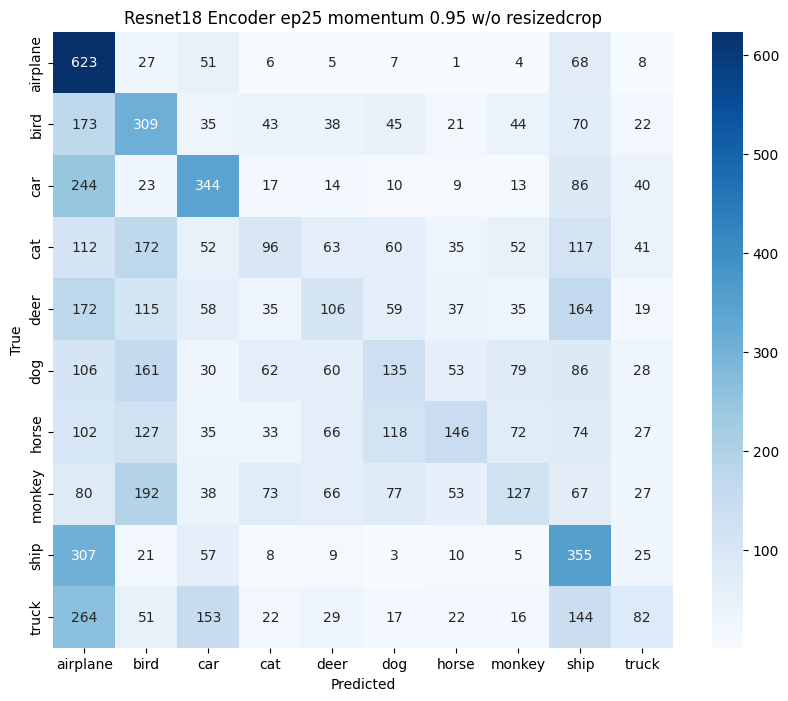

              precision    recall  f1-score   support

    airplane       0.29      0.78      0.42       800
        bird       0.26      0.39      0.31       800
         car       0.40      0.43      0.42       800
         cat       0.24      0.12      0.16       800
        deer       0.23      0.13      0.17       800
         dog       0.25      0.17      0.20       800
       horse       0.38      0.18      0.25       800
      monkey       0.28      0.16      0.20       800
        ship       0.29      0.44      0.35       800
       truck       0.26      0.10      0.15       800

    accuracy                           0.29      8000
   macro avg       0.29      0.29      0.26      8000
weighted avg       0.29      0.29      0.26      8000

Accuracy: 29.04%


In [24]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns


def plot_confusion_matrix(y_true, y_pred, classes, save_path=None):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Resnet18 Encoder ep25 momentum 0.95 w/o resizedcrop")
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

plot_confusion_matrix(y_true, y_pred, classes=train_set.classes, save_path="conf_mat_resnet18_25_ep_m_095_wo_resizedcrop.png")
print(classification_report(y_true, y_pred, target_names=train_set.classes))
print(f"Accuracy: {accuracy_score(y_true, y_pred) * 100:.2f}%")



| Ex. No. | Base Encoder | MLP Head | Queue Size | Mtm |Temp. | Trainable Params |Num Epochs | Learning Rate | Training Time (on unlabeled) | Accuracy on TrainingSet | Accuracy on TestSet|
| ------ | ------ | ------ | ------ | ------ | ------ | ------ | ----- | ------| -------| ----| --- |
| 1 | ResNet18  | False | 65,536 | 0.999 | 0.07 |11,242,176 | 10 | 0.001 | 8 Hours 13 Min| 45.76% | 29.21% |
| 2 | ResNet18  | False | 65,536 | 0.999 | 0.07 |11,242,176 | 10 | 0.01 | 7 Hours 40 Min| 36.8% | 21.26% |
| 3 | ResNet18  | False | 65,536 | 0.999 | 0.07 |11,242,176 | 10 | 0.03 | 8 Hours 10 Min| 33.84% | 20.19% |
| 4 | ResNet18  | False | 65,536 | 0.999 | 0.09 |11,242,176 | 10 | 0.001 | 8 Hours 53 Min| 46.78% | 28.81% |
| 5 | ResNet18  | False | 65,536 | 0.999 | 0.05 |11,242,176 | 10 | 0.001 | 8 Hours 48 Min| 45.56% | 24.86% |
| 6 | ResNet50  | False | 65,536 | 0.999 | 0.05 |23,770,304 | 10 | 0.001 | 20 Hours 10 Min| 41.42% | 24.52% |
| 7 | ResNet18  | False | 65,536 | 0.999 | 0.07 |11,242,176 | 20 | 0.001 | 16 Hours 8 Min| 46.24% | 30.63% |
| 8 | ResNet18  | False | 65,536 | 0.999 | 0.07 |11,242,176 | 30 | 0.001 | 26 Hours 21 Min | 42.86% | 32.15% |
| 9 | ResNet18  | False | 32,768 | 0.95 | 0.07 |11,242,176 | 15 | 0.001 | 13 Hours 26 Min| 42.65% | 31.95% |
| 10 | ResNet18  | False | 32,768 | 0.95 | 0.07 |11,242,176 | 25 | 0.001 | 19 Hours 15 Min| 55.9% | 33.89% |